In [18]:
import pandas as pd
import requests
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, mean_squared_error, r2_score
from plotnine import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Clean DataFrames
def cleanDF(df):
    """
    Input: Pandas DataFrame
    Output: Cleaned Pandas DataFrame
    """
    all_cols = ['ID', 'Language', 'Subscription Type', 'Subscription Event Type',
                'Purchase Store', 'Purchase Amount', 'Currency',
                'Subscription Start Date', 'Subscription Expiration', 'Demo User',
                'Free Trial User', 'Free Trial Start Date', 'Free Trial Expiration',
                'Auto Renew', 'Country', 'User Type', 'Lead Platform',
                'Email Subscriber', 'Push Notifications', 'Send Count', 'Open Count',
                'Click Count', 'Unique Open Count', 'Unique Click Count',
                'App Session Platform', 'App Activity Type', 'App Session Date']

    category_cols = ['Language', 'Subscription Type', 'Subscription Event Type', 'Purchase Store',
                    'Currency', 'Country', 'User Type', 'Lead Platform',
                    'App Session Platform', 'App Activity Type']

    int_cols = ['ID', 'Send Count', 'Open Count', 'Click Count', 'Unique Open Count', 'Unique Click Count']

    date_cols = ['Subscription Start Date', 'Subscription Expiration',
                'App Session Date', 'Free Trial Start Date', 'Free Trial Expiration']

    bool_cols = ['Demo User', 'Free Trial User', 'Auto Renew',
                'Email Subscriber', 'Push Notifications']

    # Keep only columns that exist in df
    all_cols = [col for col in all_cols if col in df.columns]
    category_cols = [col for col in category_cols if col in df.columns]
    int_cols = [col for col in int_cols if col in df.columns]
    date_cols = [col for col in date_cols if col in df.columns]
    bool_cols = [col for col in bool_cols if col in df.columns]

    # if 'Auto Renew' is in df.columns
    if 'Auto Renew' in df.columns:
        # convert to True/False
        df['Auto Renew'] = df['Auto Renew'].replace({'On': True, 'Off': False})

    # convert na to 0 in int_cols
    df[int_cols] = df[int_cols].fillna(0)

    # df[category_cols] = df[category_cols].astype('category')
    df[int_cols] = df[int_cols].astype('int64')
    df[date_cols] = df[date_cols].astype('datetime64[ns]')
    # df[bool_cols] = df[bool_cols].astype('bool')
    # convert bool cols to 1 or 0
    df[bool_cols] = df[bool_cols].astype('int64')
    

    return df

# Fix the Purchase Amounts with the extra 0s at the end 
def transform_value(value):
    if pd.isnull(value):
        return value
    value_str = str(int(value))
    if value_str.endswith('0000'):
        value_int = int(value / 10000)
        return float(value_int / 100)
    else:
        return value

#fetch exchange rates for the currency 
def fetch_exchange_rates(api_key, currencies):
    currency_list = ','.join(currencies)
    url = f'https://openexchangerates.org/api/latest.json?app_id={api_key}&symbols={currency_list}'
    response = requests.get(url)
    
    if response.status_code == 200:
        return response.json()['rates']
    else:
        raise ValueError(f"Failed to fetch exchange rates. Status code: {response.status_code}")

#convert to USD
def convert_to_usd(amount, currency, exchange_rates):
    if currency in exchange_rates:
        return amount / exchange_rates[currency]
    else:
        return amount

# Convert currencies to USD
def convert_currencies_to_usd(data_frame, amount_column, currency_column, exchange_rates):
    data_frame[amount_column] = data_frame.apply(lambda row: convert_to_usd(row[amount_column], row[currency_column], exchange_rates), axis=1)
    return data_frame


## Data Engineering:

In [2]:

# CREATE MERGED DF

# clean subscriberDF 
subscriberDF = pd.read_csv('../data/Original_Subscriber_Information.csv')
subscriberDF['Purchase Amount'] = subscriberDF['Purchase Amount'].apply(transform_value)

# List of all currencies
currencies = [
    'AED', 'AUD', 'BGN', 'BRL', 'CAD', 'CHF', 'CLP', 'COP', 'CRC', 'CZK',
    'DKK', 'EGP', 'EUR', 'GBP', 'GHS', 'HKD', 'HUF', 'IDR', 'ILS', 'INR',
    'JPY', 'KRW', 'KZT', 'LBP', 'MXN', 'MYR', 'NOK', 'NZD', 'PEN', 'PHP',
    'PLN', 'QAR', 'RON', 'RSD', 'RUB', 'SAR', 'SEK', 'SGD', 'THB', 'TRY',
    'UAH', 'VND', 'ZAR'
]

api_key = '418dd91a76a743c7bee44a1feb77fe51'
exchange_rates = fetch_exchange_rates(api_key, currencies)

subscriberDF = convert_currencies_to_usd(subscriberDF, 'Purchase Amount', 'Currency', exchange_rates)


# Drop rows with null values in the App Activity data
appDF = pd.read_csv('../data/Original_App_activity.csv')
appDF.dropna()
appDF = appDF.dropna(subset=['App Activity Type', 'App Session Platform', 'App Session Date'])

# appDF.to_csv('../data/app_nonull.csv', index=False)                   # save to csv



# Use currencies to determine the country of the subscriber
# this is a dictionary of currency to country
currency_to_country = {
    'AED': 'United Arab Emirates',
    'AUD': 'Australia',
    'BGN': 'Bulgaria',
    'BRL': 'Brazil',
    'CAD': 'Canada',
    'CHF': 'Switzerland',
    'CLP': 'Chile',
    'COP': 'Colombia',
    'CRC': 'Costa Rica',
    'CZK': 'Czech Republic',
    'DKK': 'Denmark',
    'EGP': 'Egypt',
    'EUR': 'European Union',
    'GBP': 'United Kingdom',
    'GHS': 'Ghana',
    'HKD': 'Hong Kong',
    'HUF': 'Hungary',
    'IDR': 'Indonesia',
    'ILS': 'Israel',
    'INR': 'India',
    'JPY': 'Japan',
    'KRW': 'South Korea',
    'KZT': 'Kazakhstan',
    'LBP': 'Lebanon',
    'MXN': 'Mexico',
    'MYR': 'Malaysia',
    'NOK': 'Norway',
    'NZD': 'New Zealand',
    'PEN': 'Peru',
    'PHP': 'Philippines',
    'PLN': 'Poland',
    'QAR': 'Qatar',
    'RON': 'Romania',
    'RSD': 'Serbia',
    'RUB': 'Russia',
    'SAR': 'Saudi Arabia',
    'SEK': 'Sweden',
    'SGD': 'Singapore',
    'THB': 'Thailand',
    'TRY': 'Turkey',
    'UAH': 'Ukraine',
    'USD': 'United States',
    'VND': 'Vietnam',
    'ZAR': 'South Africa'
}

#skip rows with na or nan in currency
subscriberDF['Country'] = subscriberDF['Currency'].apply(lambda currency: currency_to_country[currency] if currency in currency_to_country else None)

# # subscriberDF.to_csv('../data/subscriberClean.csv', index=False)     # save to csv


# This is how we merge the two dataframes
merged_df = subscriberDF.merge(appDF, on='ID', how='left')


# Aggregate the app data by ID
app_agg = appDF.pivot_table(index='ID', columns='App Activity Type', values='App Session Platform', aggfunc='count', fill_value=0)
app_agg = app_agg.join(appDF.pivot_table(index='ID', columns='App Session Platform', values='App Activity Type', aggfunc='count', fill_value=0), rsuffix='_App_Session_Platform')
app_agg = app_agg.join(appDF.groupby('ID').agg({'App Session Date': ['min', 'max']}))

# Rename the columns
app_agg.rename(columns={'android': 'Android Uses'}, inplace=True)
app_agg.rename(columns={'ios': 'iOS Uses'}, inplace=True)
app_agg.rename(columns={'web': 'Web Uses'}, inplace=True)

app_agg.rename(columns={('App Session Date', 'min'): 'First App Session'}, inplace=True)
app_agg.rename(columns={('App Session Date', 'max'): 'Last App Session'}, inplace=True)

# drop repead ID's 
subscriberDF = subscriberDF.drop_duplicates(subset=['ID'])

# merge the two dataframes
aggregatedDF = subscriberDF.merge(app_agg, on='ID', how='left')


# Churn criteria: Subscription expiration date is before March 31st, 2020, or
# (auto-renew is off and the count of non-empty App Activity Types is less than a threshold, e.g., 5)
def determine_churn(row):
    threshold = 4
    churned = (pd.to_datetime(row['Subscription Expiration']) < pd.Timestamp('2020-03-31') or
               (row['Auto Renew'] == 0 and (row['Android Uses'] + row['iOS Uses'] + row['Web Uses']) < threshold))
    return int(churned)

aggregatedDF['Churn'] = aggregatedDF.apply(determine_churn, axis=1)


## save to csv
# aggregatedDF.to_csv('../data/aggregatedClean.csv', index=False)
# merged_df.to_csv("../data/mergedClean.csv")


C:\Users\austi\AppData\Local\Temp\ipykernel_28760\3306729029.py:93: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)


In [28]:
#### Feature Engineering for aggregated data ####
features = aggregatedDF.columns
features = features.drop(['ID', 'Subscription Expiration', 'Currency',
                         'Auto Renew', 'First App Session', 'Last App Session'])

aggDF = pd.read_csv('../data/aggregatedClean.csv')

# the dates don't make sense to use for most of our models
# ID should not be a feature to fit on
# currency and country have the exact same information
X = aggDF.drop(['ID', 'Currency',
                # 'Purchase Amount',
                'Subscription Start Date', 'Subscription Expiration',
                'Free Trial Start Date', 'Free Trial Expiration', 'First App Session',
                'Last App Session'], axis=1)
# y = aggDF['Purchase Amount']

# sum ['Android Uses', 'iOS Uses', 'Web Uses'] to 'Total Uses'
# X['Total Uses'] = X['Android Uses'] + X['iOS Uses'] + X['Web Uses']
# X = X.drop(['Android Uses', 'iOS Uses', 'Web Uses'], axis=1)

# bool_cols = columns where nunique() == 2
bool_cols = [col for col in X.columns if X[col].nunique() == 2]

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop(['Churn'])

categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.append(pd.Index(['Churn']))
categorical_cols = categorical_cols.drop(list(bool_cols) + ['Churn'])


# convert bool_cols to int
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# fill null with 0's (all columns with null make sense to be 0)
X = X.fillna(0)

# one hot encodeing
X = pd.get_dummies(X)

# z-score normalization
scaler = StandardScaler()
X_zscored = X.copy()
X_zscored[numeric_cols] = scaler.fit_transform(X[numeric_cols])


# Train Test Split is per model based on which features we want to use and predict

## Feature Importance:

113
113
               Column  expl_var  pc   cum_var
0     Purchase Amount  0.241327   0  0.241327
1          Send Count  0.155976   1  0.397303
2          Open Count  0.096870   2  0.494173
3         Click Count  0.064195   3  0.558368
4   Unique Open Count  0.053232   4  0.611600
5  Unique Click Count  0.050973   5  0.662573
6          App Launch  0.049637   6  0.712210
7           Completed  0.042714   7  0.754924
8          Onboarding  0.035585   8  0.790509
9               Other  0.031305   9  0.821814


c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 14 rows containing missing values.
c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:411: PlotnineWarning: geom_point : Removed 14 rows containing missing values.


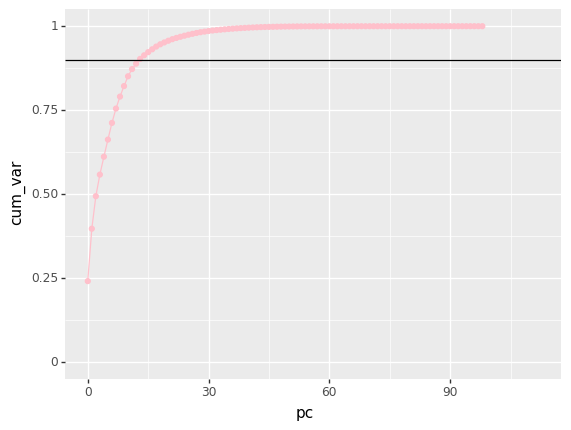

In [29]:
# PCA
pca = PCA(random_state=42)

pca.fit(X_zscored)

print(len(pca.explained_variance_ratio_))
print(len(pca.explained_variance_ratio_.cumsum()))

pcaDF = pd.DataFrame({"Column": X.columns,
                      "expl_var":
                      pca.explained_variance_ratio_,
                      "pc": range(0, len(pca.explained_variance_ratio_)),
                      "cum_var":
                      pca.explained_variance_ratio_.cumsum()})

print(pcaDF.head(10))


print((ggplot(pcaDF, aes(x="pc", y="cum_var")) +
       geom_line(color="pink") +
       geom_point(color="pink") +
       geom_hline(yintercept=0.90) +
       ylim(0, 1)))
# 

## Linear Regression

In [41]:
# Linear Regression

# X = all except dates, ID, and Currency (we have country)
Xnew = X.copy()
y = Xnew['Purchase Amount']
xNew = Xnew.drop(['Purchase Amount'], axis = 1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(Xnew,y, test_size = 0.2)

# z-score normalization
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("----------------------------------------------")
print("Train MSE:       ", train_mse)
print("Test MSE:        ", test_mse)
print()
print("Train R2 Score:  ", train_r2)
print("Test R2 Score:   ", test_r2)
print("----------------------------------------------")

# Cross Validation

lm = LinearRegression()
# Perform cross-validation on training set
cv_results = cross_validate(lm, X_train, y_train, cv=5, scoring='r2')

# Extract cross-validation scores
cv_scores = cv_results['test_score']
mean_cv_score = cv_scores.mean()

# Fit the model on the entire training set
lm.fit(X_train, y_train)

# Evaluate on the test set
test_score = lm.score(X_test, y_test)

print("Cross-Validation R2 Scores:", cv_scores)
print("Mean Cross-Validation R2 Score:", mean_cv_score)
print("Test R2 Score:", test_score)



----------------------------------------------
Train MSE:        9.823990897403705e-24
Test MSE:         0.0016306994143486242

Train R2 Score:   1.0
Test R2 Score:    0.9999996678570898
----------------------------------------------
Cross-Validation R2 Scores: [0.99999638 0.99998144 0.9984545  1.         0.99981736]
Mean Cross-Validation R2 Score: 0.9996499352108696
Test R2 Score: 0.9999996678570898


In [42]:
# linear regression using top 12 features from PCA
# X = all except dates, ID, and Currency (we have country)
Xnew = X.copy()
y = Xnew['Purchase Amount']
xNew = Xnew.drop(['Purchase Amount'], axis = 1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(Xnew,y, test_size = 0.2, random_state=42)

# z-score normalization
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# PCA
pca = PCA(n_components=12, random_state=42)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Linear Regression
lm = LinearRegression()
lm.fit(X_train_pca, y_train)

y_pred_train = lm.predict(X_train_pca)
y_pred_test = lm.predict(X_test_pca)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("----------------------------------------------")
print("Train MSE:       ", train_mse)
print("Test MSE:        ", test_mse)
print()
print("Train R2 Score:  ", train_r2)
print("Test R2 Score:   ", test_r2)
print("----------------------------------------------")


# Cross Validation
lm = LinearRegression()
# Perform cross-validation on training set
cv_results = cross_validate(lm, X_train_pca, y_train, cv=5, scoring='r2')

# Extract cross-validation scores
cv_scores = cv_results['test_score']
mean_cv_score = cv_scores.mean()

# print results
print("Cross-Validation R2 Scores:      ", cv_scores)
print("Mean Cross-Validation R2 Score:  ", mean_cv_score)




----------------------------------------------
Train MSE:        209.09065773705998
Test MSE:         198.1311287006125

Train R2 Score:   0.9584310892977587
Test R2 Score:    0.9596733351487826
----------------------------------------------
Cross-Validation R2 Scores:       [0.95736884 0.95775118 0.95980773 0.9581002  0.95858878]
Mean Cross-Validation R2 Score:   0.9583233459467932


## Clustering models:

Index([], dtype='object')


c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\U

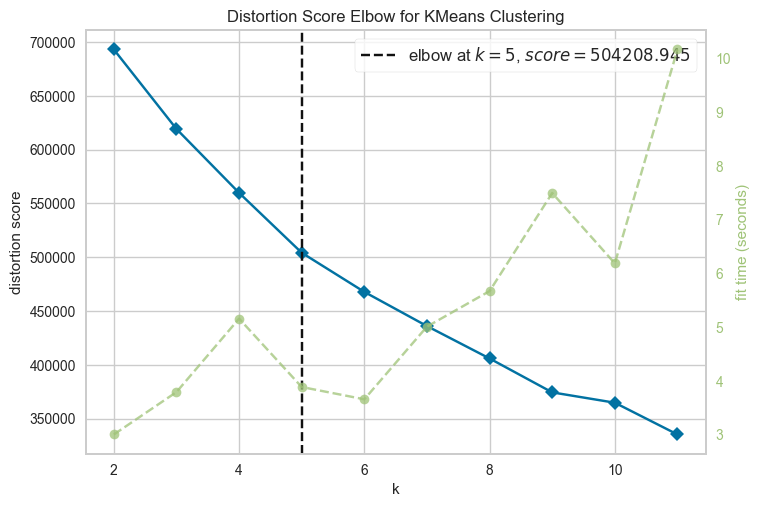

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
# Clustering models
Xnew = X.copy()
# print columns with nulls
print(Xnew.columns[Xnew.isnull().any()])

# zsore normalization
scaler = StandardScaler()
Xnew[numeric_cols] = scaler.fit_transform(Xnew[numeric_cols])

# kmeans
# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,12))
 
visualizer.fit(Xnew)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\U

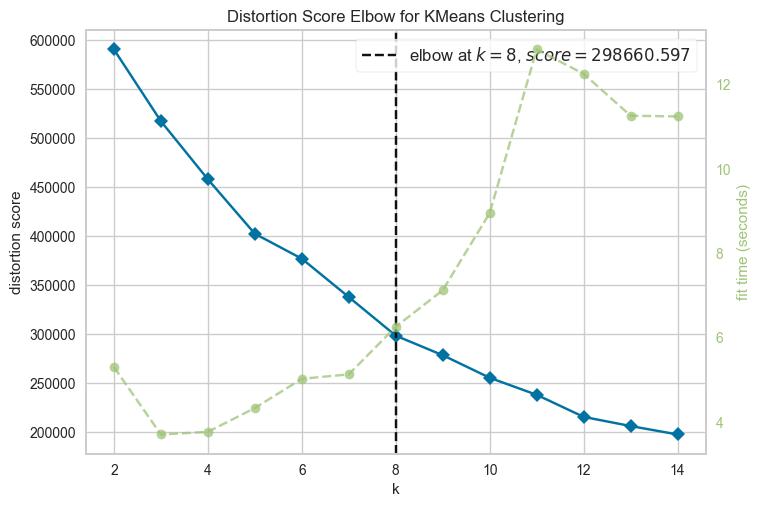

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
# cluster with top 12 features from PCA
# PCA
Xnew = X.copy()

# zsore normalization
scaler = StandardScaler()
Xnew[numeric_cols] = scaler.fit_transform(Xnew[numeric_cols])

pca = PCA(n_components=12, random_state=42)
pca.fit(Xnew)
Xnew_pca = pca.transform(Xnew)

# kmeans
# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,15))

visualizer.fit(Xnew_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

